In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import tikzplotlib
import timeit

In [3]:
# This section is just me figuring out how tensors work
#lower_bound = tf.zeros(shape=[1,1]) # Lower bound u(0)=0
#upper_bound = tf.ones(shape=[1,1]) # Upper bound u(1)=1
#x = tf.random.uniform(shape=[1,100]) # Interior points
#training_pts = tf.concat([lower_bound, x, upper_bound], 1) # Actual training data
#x_0 = tf.slice(training_pts, [0,0], [1,1])
#x_1 = tf.slice(training_pts, [0,101], [1,1])
#print(x_0.numpy(), x_1.numpy())

In [25]:
# Construct Simple Feedforward Network
model = Sequential()
model.add(Dense(100, input_shape=[1], activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
# Define Loss Function
def loss_fn(model,x):
    #print(x)
    with tf.GradientTape() as tt:
        tt.watch(x)
        with tf.GradientTape() as t:
            t.watch(x)
            f = model(x, training=True)
            #print('f = ', f)
        df_dx = t.gradient(f,x)
        #print(df_dx)
    d2f_dx2 = tt.gradient(df_dx,x)
    #print(d2f_dx2)
    
    u_0 = tf.zeros(shape=[1,1]) # Lower boundary condition
    u_1 = tf.ones(shape=[1,1]) # Upper boundary condition
    bound_weight = 1 # lambda = sqrt(bound_weight)
    mse = tf.keras.losses.MeanSquaredError()
    lower_bound_error = tf.math.subtract(tf.slice(f,[0,0],[1,1]),u_0)
    #print(lower_bound_error)
    upper_bound_error = tf.math.subtract(tf.slice(f,[99,0], [1,1]),u_1)
    loss_1 = tf.math.add(tf.nn.l2_loss(d2f_dx2), 
                       tf.nn.l2_loss(bound_weight*lower_bound_error))
    loss = tf.math.add(loss_1, tf.nn.l2_loss(bound_weight*upper_bound_error))
    return loss

In [20]:
def train():    
    # Train network
    optimizer = tf.keras.optimizers.Adam() # Fancy gradient decent
    epochs = 20
    train_loss_results = [] # For tracking loss during training
    iterations_per_epoch = 100
    minibatch_size = 100 # Number of points to be selected each iteration
    #for epoch in range(epochs): # Uncomment to run for specific number of epochs
    average_error = 1
    epoch = -1
    while average_error > 0.002: 
        epoch_loss_avg = tf.keras.metrics.Mean()
        for iteration in range(iterations_per_epoch):
            lower_bound = tf.zeros(shape=[1,1]) # Lower bound u(0)=0
            upper_bound = tf.ones(shape=[1,1]) # Upper bound u(1)=1
            interior_pts = tf.random.uniform(shape=[1,minibatch_size-2]) # Interior points
            x = tf.transpose(tf.concat([lower_bound, interior_pts, upper_bound], 1)) # Actual training data
            with tf.GradientTape() as t:
                t.watch(x)
                #print(x)
                #f = model(x, training=True) # Estimate for u
                loss = loss_fn(model,x) # Loss
            grads = t.gradient(loss, model.trainable_weights) # Find model gradients
            optimizer.apply_gradients(zip(grads,model.trainable_weights)) # Perform gradient decent
            epoch_loss_avg.update_state(loss) # Track loss
            # End training iteration
        # Check average error    
        lower_bound = tf.zeros(shape=[1,1]) # Lower bound u(0)=0
        upper_bound = tf.ones(shape=[1,1]) # Upper bound u(1)=1
        x = tf.sort(tf.random.uniform(shape=[1,98])) # Interior points
        test_points_tensor = tf.transpose(tf.concat([lower_bound, x, upper_bound], 1)) # Actual data
        test_points = test_points_tensor.numpy()
        g = model(test_points_tensor, training=False).numpy()
        average_error = np.sum(abs(g-test_points))/len(g)
        print(average_error)
        
        train_loss_results.append(epoch_loss_avg.result())
        epoch+=1 
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
        # End Epoch

0.003192731440067291
Epoch 000: Loss: 0.067
0.0010642269998788834
Epoch 001: Loss: 0.000


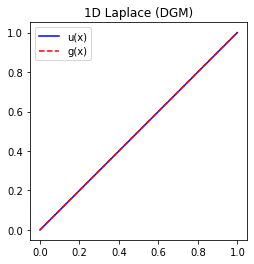

In [21]:
# Run the model with real data
train()
lower_bound = tf.zeros(shape=[1,1]) # Lower bound u(0)=0
upper_bound = tf.ones(shape=[1,1]) # Upper bound u(1)=1
x = tf.sort(tf.random.uniform(shape=[1,98])) # Interior points
test_points_tensor = tf.transpose(tf.concat([lower_bound, x, upper_bound], 1)) # Actual data
test_points = test_points_tensor.numpy()
g = model(test_points_tensor, training=False).numpy()
x_actual = tf.sort(tf.random.uniform(shape=[1,1000]).numpy()) # Known solution
#print(test_points[0])
#print(x_actual[0])
#print(f[0])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('1D Laplace (DGM)')
ax.plot(x_actual[0],x_actual[0], label='u(x)', color='blue')
ax.plot(test_points,g,'r--', label='g(x)')
ax.legend()
ax.set_aspect('equal','box')

tikzplotlib.save("1d_laplace_dgm.tex")

#average_error = np.sum(abs(g-test_points))/len(g)
#print(average_error)

In [26]:
print(timeit.timeit(train, number=1))

0.004246308207511902
Epoch 000: Loss: 0.067
0.001572984755039215
Epoch 001: Loss: 0.000
5.927197528999841
